# Pre-processing analysis

The aim of this notebook is to analyse the pre-processing steps that are applied to data. We have a reference TextPreprocessor class that is used to pre-process the data. We will try to improve the pre-processing steps by analysing the data and comparing the results of new steps with the reference.

---

## Imports

First we import the necessary modules and classes.


In [32]:
from textprocessor import (
    CustomTextProcessor,
    ReferenceTextProcessor,
    ReferenceRearrangedTextProcessor,
)
from sklearn.linear_model import LinearRegression
from difflib import SequenceMatcher
import xml.etree.ElementTree as ET
from colorama import Fore, Style
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
from tqdm import tqdm
import pandas as pd
import numpy as np
import zipfile
import json
import re
import os
import re

We define a function to pre-process the collection using the reference TextPreprocessor class. This will generate a folder with the pre-processed data in txt format.


In [33]:
def pre_process_collection(collection_path, processed_dir):
    processor = ReferenceTextProcessor()
    with zipfile.ZipFile(collection_path, "r") as zip_ref:
        xml_file_name = zip_ref.namelist()
        for file in tqdm(xml_file_name, desc="Processing files"):
            with zip_ref.open(file) as xml_file:
                xml_content = xml_file.read().decode("utf-8")

                xml_content = re.sub(r"<[^>]+>", " ", xml_content)
                xml_content = re.sub(r"&[^;]+;", " ", xml_content)
                xml_content = processor.pre_processing(xml_content)
                xml_content = " ".join(xml_content)

                processed_xml_file_path = (
                    f"{processed_dir}{file.split('/')[1].split('.')[0]}.txt"
                )

                # Save the processed XML content to a new XML file
                with open(
                    processed_xml_file_path, "w", encoding="utf-8"
                ) as processed_file:
                    processed_file.write(xml_content)

In [34]:
collection_name = "XML-Coll-withSem"
collection_path = f"../lib/data/practice_05/{collection_name}" + ".zip"
processed_dir = f"../lib/processed_data/reference/{collection_name}/"
os.makedirs(processed_dir, exist_ok=True)

**UNCOMMENT** the following cell if you want to pre-process the data with the `ReferenceTextPreprocessor` class.


In [35]:
# pre_process_collection(collection_path, processed_dir)

## Overall Statistics of the Collection

We will start by analysing the overall statistics of the collection. We will now read the pre-processed data and compute the statistics. We will store the following data for each document inside a dataframe:

- Docno
- Document length
- Number of unique words
- words

And then for the collection we will compute :

- avg collection lengths
- avg term lengths in collection
- collection vocabulary sizes
- collection frequency of terms


In [36]:
def compute_statistics(text, docno, stats_data, all_unique_words):
    words = text.split()

    all_unique_words.update(words)

    unique_words = set(words)
    stats_data.append(
        {
            "Docno": docno,
            "Document length": len(words),
            "Number of unique words": len(unique_words),
            "Words": words,
        }
    )

    return len(words)


def print_collection_statistics(
    avg_doc_length, avg_word_length, total_unique_words, total_words
):
    stats = {
        "Average document length": avg_doc_length,
        "Average word length": avg_word_length,
        "Total unique words": total_unique_words,
        "Total words": total_words,
    }

    print(
        tabulate(
            stats.items(),
            headers=["Statistic", "Value"],
            tablefmt="fancy_grid",
            numalign="center",
        )
    )
    return stats


def save_collection_statistics(stats, file_path):
    with open(f"{file_path}", "w") as f:
        json.dump(stats, f, indent=4)

We comput the stats on the previous preprocessing method.


In [37]:
stats_data = []

total_words = 0
all_unique_words = set()

for file in tqdm(os.listdir(processed_dir), desc="Computing statistics"):
    with open(processed_dir + file, "r", encoding="utf-8") as processed_file:
        content = processed_file.read()
        docno = file.split(".")[0]

        total_words += compute_statistics(content, docno, stats_data, all_unique_words)


stats_df = pd.DataFrame(stats_data)
total_unique_words = len(all_unique_words)
avg_doc_length = stats_df["Document length"].mean()
avg_word_length = sum(len(word) for word in all_unique_words) / total_unique_words

Computing statistics:  18%|█▊        | 1751/9804 [00:00<00:00, 8246.15it/s]

Computing statistics: 100%|██████████| 9804/9804 [00:01<00:00, 8111.48it/s]


In [38]:
statistics = print_collection_statistics(
    avg_doc_length, avg_word_length, total_unique_words, total_words
)
save_collection_statistics(
    statistics, f"../lib/processed_data/reference/{collection_name}_stats.json"
)

╒═════════════════════════╤═════════════╕
│ Statistic               │    Value    │
╞═════════════════════════╪═════════════╡
│ Average document length │   654.008   │
├─────────────────────────┼─────────────┤
│ Average word length     │   8.39066   │
├─────────────────────────┼─────────────┤
│ Total unique words      │   210232    │
├─────────────────────────┼─────────────┤
│ Total words             │ 6.41189e+06 │
╘═════════════════════════╧═════════════╛


We now compute the stats on the collection that has been pre-processed with the new method.


In [39]:
stats_data_2 = []

total_words_2 = 0
all_unique_words_2 = set()

with zipfile.ZipFile(
    "../lib/processed_data/XML-Coll-withSem_stop670_porter_ref_rearranged.zip", "r"
) as zip_ref:
    xml_file_name = zip_ref.namelist()
    for file in tqdm(xml_file_name, desc="Processing files"):
        with zip_ref.open(file) as xml_file:
            xml_content = xml_file.read().decode("utf-8")
            root = ET.fromstring(xml_content)
            xml_content = " ".join(root.itertext())

            # Extract 'docno' from the file name
            docno = file.split("/")[1].split(".")[0]
            total_words_2 += compute_statistics(
                xml_content, docno, stats_data_2, all_unique_words_2
            )

stats_df_2 = pd.DataFrame(stats_data_2)
total_unique_words_2 = len(all_unique_words_2)
avg_doc_length_2 = stats_df_2["Document length"].mean()
avg_word_length_2 = sum(len(word) for word in all_unique_words_2) / total_unique_words_2

Processing files: 100%|██████████| 9804/9804 [00:07<00:00, 1346.19it/s]


In [40]:
statistics_2 = print_collection_statistics(
    avg_doc_length_2, avg_word_length_2, total_unique_words_2, total_words_2
)

╒═════════════════════════╤═════════════╕
│ Statistic               │    Value    │
╞═════════════════════════╪═════════════╡
│ Average document length │   628.267   │
├─────────────────────────┼─────────────┤
│ Average word length     │   9.22707   │
├─────────────────────────┼─────────────┤
│ Total unique words      │   226564    │
├─────────────────────────┼─────────────┤
│ Total words             │ 6.15953e+06 │
╘═════════════════════════╧═════════════╛


Let's also make a quick comparison of the frequency of the terms of the queries inside the collection.


In [42]:
def pre_process_queries(queries, processor):
    pre_processed_queries = [processor.pre_processing(query) for query in queries]
    return pre_processed_queries


def count_words_frequency(pre_processed_queries, df):
    query_word_counts = Counter()
    for pre_processed_query in pre_processed_queries:
        for words in df["Words"]:
            query_word_counts.update(
                [word for word in words if word in pre_processed_query]
            )

    return query_word_counts


queries = [
    "olive oil health benefit",
    "notting hill film actors",
    "probabilistic models in information retrieval",
    "web link network analysis",
    "web ranking scoring algorithm",
    "supervised machine learning algorithm",
    "operating system mutual exclusion",
]

In [43]:
pre_processed_queries = pre_process_queries(queries, ReferenceTextProcessor())
pre_processed_queries_2 = pre_process_queries(
    queries, ReferenceRearrangedTextProcessor()
)

query_word_counts = count_words_frequency(pre_processed_queries, stats_df)
query_word_counts_2 = count_words_frequency(pre_processed_queries_2, stats_df_2)

In [44]:
word_counts = {
    "Original method": dict(query_word_counts),
    "New method": dict(query_word_counts_2),
    "Frequency difference": {
        word: query_word_counts_2[word] - query_word_counts[word]
        for word in query_word_counts
    },
}

table = []
for word, counts in word_counts.items():
    table.append([word] + [counts.get(key, 0) for key in sorted(query_word_counts)])

# Insert header with word columns
header = [""] + sorted(query_word_counts)

# Display the table
print(tabulate(table, headers=header))

overall_difference = sum(word_counts["Frequency difference"].values())
print("----------------------------------------")
print(f"Overall difference: {overall_difference}")

                        actor    algorithm    analysi    benefit    exclus    film    health    hill    inform    learn    link    machin    model    mutual    network    oil    oliv    oper    probabilist    rank    retriev    score    supervis    system    web
--------------------  -------  -----------  ---------  ---------  --------  ------  --------  ------  --------  -------  ------  --------  -------  --------  ---------  -----  ------  ------  -------------  ------  ---------  -------  ----------  --------  -----
Original method          7115        35312       8143       4716      1893   16708     11414    4526     17490     6027   12306      9165    15424      2711      17912  14407    3025   16621           1229    3673      13578     4198         589     38947  20188
New method               7113        35326       8164       4716      1891   16708     11411    4526     17512     6028   12306      9160    15422      2711      17968  14409    3027   16622           1229    36

## Term Frequency Distribution

We found out that the term frequency of the collection is not following a Zipf law distribution. It might be because of the pre-processing steps that are applied to the data. We will now analyse the term frequency distribution of the collection and compare it with the reference.


In [45]:
def compute_zipf_parameters(all_words):
    word_occurrences = Counter(all_words)
    sorted_words = sorted(word_occurrences.items(), key=lambda x: x[1], reverse=True)
    ranks = list(range(1, len(sorted_words) + 1))
    frequencies = [freq for _, freq in sorted_words]

    model = LinearRegression().fit(np.log(ranks).reshape(-1, 1), np.log(frequencies))

    return frequencies, ranks, model


def plot_zipf_law(ax, frequencies, ranks, model, dataset_name):
    ax.scatter(ranks, frequencies, color="blue", s=5, label=dataset_name)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title("Zipf's Law - Word Frequency Distribution")
    ax.set_xlabel("Word Rank")
    ax.set_ylabel("Word Frequency")

    # Plot the linear regression line
    log_ranks = np.log(ranks).reshape(-1, 1)
    ax.plot(
        ranks,
        np.exp(model.predict(log_ranks)),
        color="red",
        linestyle="-",
        linewidth=2,
        label="Linear Regression",
    )

    ax.legend()
    ax.grid(True)


def print_conclusion(slope, dataset_name):
    print(f"Estimated slope for {dataset_name} (power law exponent): {slope}")
    print(f"Slope + 1: {abs(slope + 1)}")
    if abs(slope + 1) < 0.1:
        print("The distribution approximately follows Zipf's Law.")
    else:
        print("The distribution does not strictly follow Zipf's Law.")

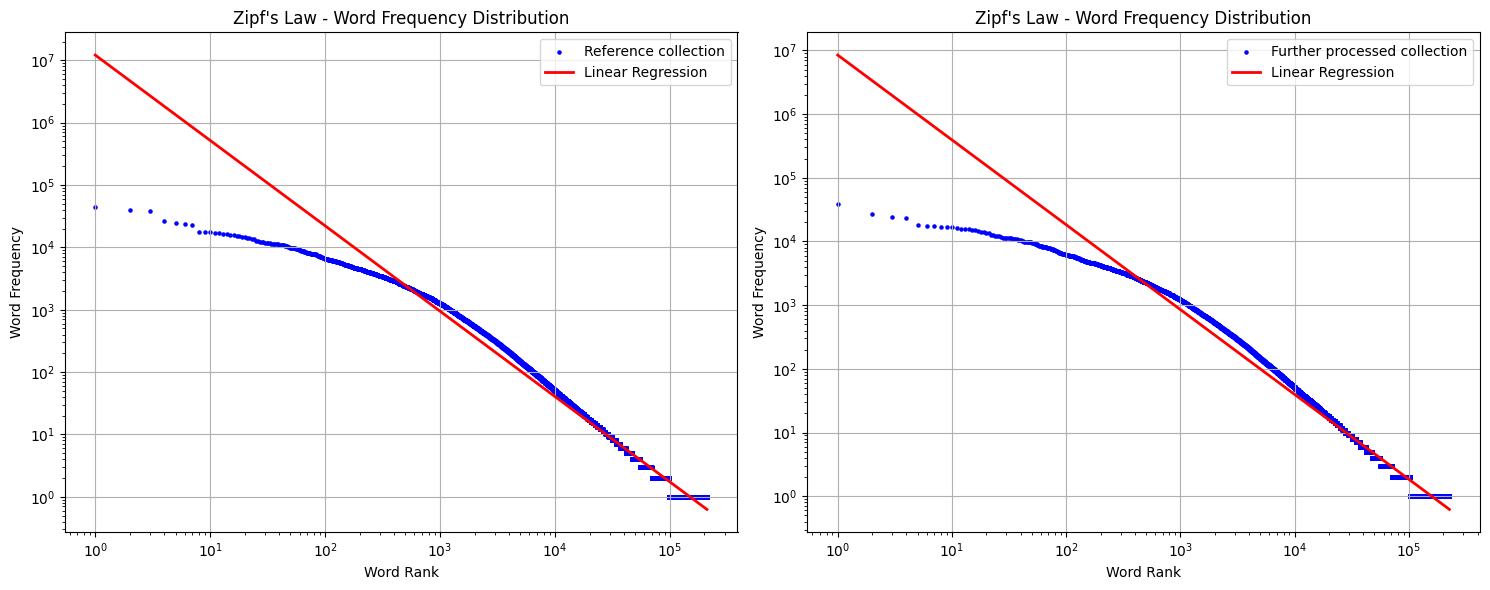

In [46]:
# First collection
all_words = [word for words_list in stats_df["Words"] for word in words_list]
frequencies, ranks, model = compute_zipf_parameters(all_words)

# Second collection
all_words_2 = [word for words_list in stats_df_2["Words"] for word in words_list]
frequencies_2, ranks_2, model_2 = compute_zipf_parameters(all_words_2)

# Plotting both Zipf's Law distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_zipf_law(ax1, frequencies, ranks, model, "Reference collection")
plot_zipf_law(ax2, frequencies_2, ranks_2, model_2, "Further processed collection")

plt.tight_layout()
plt.show()

In [47]:
# Output the slope (power law exponent) for both collections
slope = model.coef_[0]
slope_2 = model_2.coef_[0]

print_conclusion(slope, "Reference collection")
print("---------")
print_conclusion(slope_2, "Further processed collection")

Estimated slope for Reference collection (power law exponent): -1.368963310392746
Slope + 1: 0.3689633103927461
The distribution does not strictly follow Zipf's Law.
---------
Estimated slope for Further processed collection (power law exponent): -1.332048566362227
Slope + 1: 0.332048566362227
The distribution does not strictly follow Zipf's Law.


## Pre-processing analysis

We will now try to improve the pre-processing steps by analysing the data after the pre-processing steps. The objective is to improve the term frequency distribution of the collection by removing the terms that are not useful for the retrieval task.


In [48]:
word_counter = Counter(all_words_2)

In [49]:
df = pd.DataFrame(word_counter.items(), columns=["Word", "Frequency"])
df = df.sort_values(by=["Frequency"], ascending=True)
df["Word Length"] = df["Word"].apply(len)

In [50]:
print(len(df))
avg_term_length = df["Word"].str.len().mean()
print(f"Average term length: {avg_term_length}")

226564
Average term length: 9.227070496636712


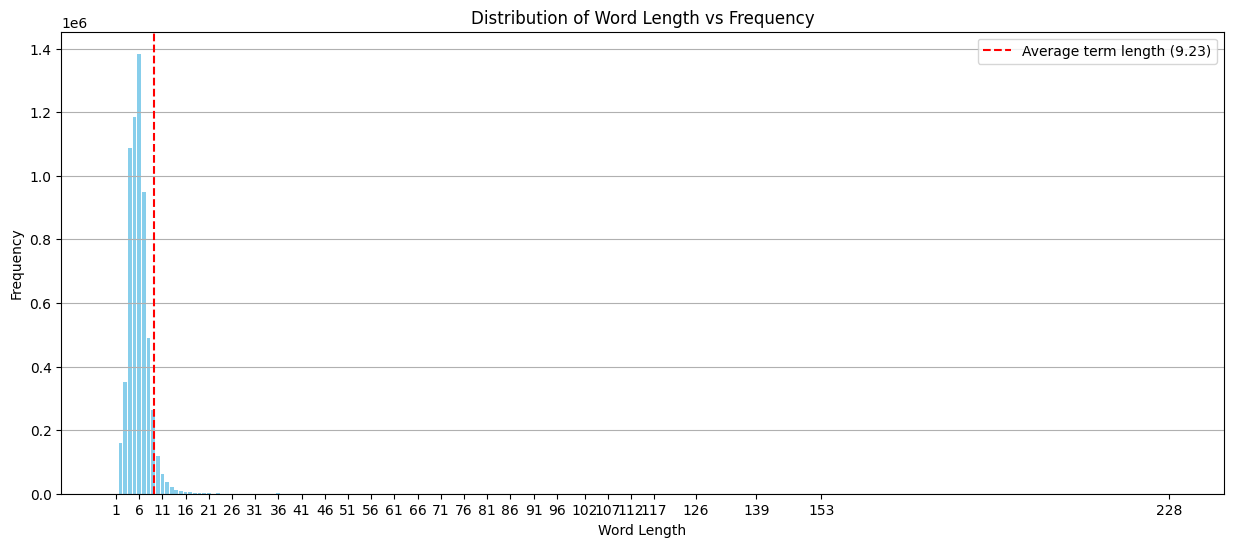

In [51]:
# Group by word length and sum the frequencies
length_freq = df.groupby("Word Length")["Frequency"].sum().reset_index()

# Plotting the distribution
plt.figure(figsize=(15, 6))
plt.bar(length_freq["Word Length"], length_freq["Frequency"], color="skyblue")
plt.title("Distribution of Word Length vs Frequency")
plt.xlabel("Word Length")
plt.ylabel("Frequency")

# Reduce the number of x-axis ticks for better readability
plt.xticks(length_freq["Word Length"].unique()[::5])

# add a curve representing the average term length
plt.axvline(
    avg_term_length,
    color="red",
    linestyle="--",
    label=f"Average term length ({avg_term_length:.2f})",
)

plt.legend()
plt.grid(axis="y")
plt.show()

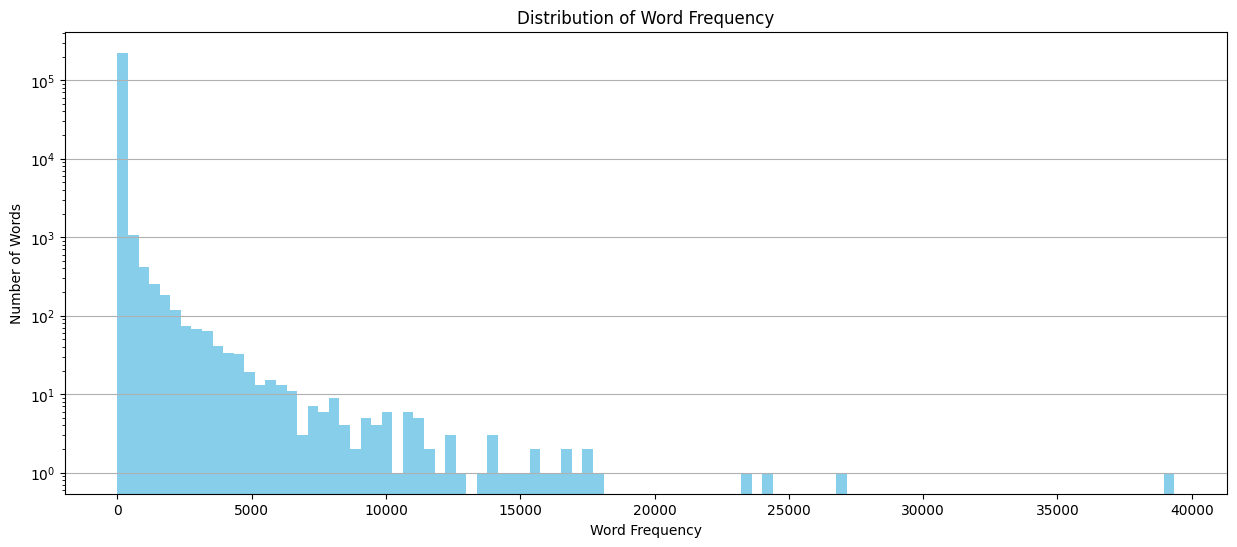

In [52]:
# plot the distribution of the frequencies of the words
plt.figure(figsize=(15, 6))
plt.hist(df["Frequency"], bins=100, color="skyblue")
plt.title("Distribution of Word Frequency")
plt.xlabel("Word Frequency")
plt.ylabel("Number of Words")
plt.grid(axis="y")
plt.yscale("log")  # Set the y-axis scale to logarithmic
plt.show()

In [53]:
# filter df with words that have length <= 4
# test = df[(df['Word Length'] <= 2 ) | (df['Word Length'] >= 30)]

inf = df[df["Word Length"] <= 2]
print("inf < 2 : ", sum(inf["Frequency"]))
sup = df[df["Word Length"] >= 15]
print("sup > 30 : ", sum(sup["Frequency"]))
test = df[(df["Word Length"] <= 2) | (df["Word Length"] >= 30)]
print("total : ", sum(test["Frequency"]))
test.sample(10)

inf < 2 :  160658
sup > 30 :  34246
total :  168740


,Word,Frequency,Word Length
20347,wu,187,2
87793,httpwwwirishsocietyorghedgemasterarchivesfive_...,1,55
202897,httpdocsnewsbankcomggooglepmdmlibfffbeabahtml,1,45
17938,httpwwwladhsorgwpsportalutpc_sbkxllmmsszpyxbzc...,1,202
165279,folkestonebrightonsouthamptondorchesterhoniton,1,46
220205,httpwwwcuisinenetcomdigestseasonspringlatevegs...,1,50
111500,httpwwwmacedonrangesvicgovaufilesresidentpokie...,1,64
47593,httpwwwmoonflarecomcodescolorq,1,30
67574,httpwwwnapedubookshtmlindexhtml,1,31
40903,httpwwwblackwellsynergycomdoiabsjxcookieset,1,43


In [54]:
print(sum(df[df["Frequency"] <= 5]["Frequency"].astype(int)))

294605


In [55]:
cpy = df.copy()
sum(cpy["Frequency"].astype(int))

6159526

In [56]:
# check if there is words that contains a character that is not a letter
special = df[df["Word"].str.contains(r"[^a-zA-Z]")]
special = df[~df["Word"].str.isalpha()]

# remove the special characters from cpy
cpy = cpy[~cpy["Word"].str.contains(r"[^a-zA-Z]")]
sum(cpy["Frequency"].astype(int))

6138027

In [57]:
# remove words that have a length <= 2 or >= 30
cpy = cpy[(cpy["Word Length"] > 2) & (cpy["Word Length"] < 30)]
sum(cpy["Frequency"].astype(int))

5974459

In [58]:
length = 5
# count the number of words that have a frequency <= 2
sum(cpy[cpy["Frequency"] <= length]["Frequency"].astype(int))

In [ ]:
# write the list of words with a frequency <= 2 in a file
# with open("../lib/processed_data/words_to_remove.txt", "w") as f:
#     for word in cpy[cpy["Frequency"] <= length]["Word"]:
#         if word.isalpha() and (len(word) > 2 and len(word) < 30):
#             f.write(word + "\n")

In [59]:
sum(cpy[cpy["Frequency"] < length]["Frequency"].astype(int))

251548

In [31]:
sum(cpy[cpy["Frequency"] > length]["Frequency"].astype(int))

5694481

In [ ]:
def generate_diff_table(file1_words, file2_words):
    matcher = SequenceMatcher(None, file1_words, file2_words)
    diff = matcher.get_opcodes()

    table_data = []
    for opcode, a_start, a_end, b_start, b_end in diff:
        if opcode == "delete":
            deleted_words = [
                Fore.RED + file1_words[i] + Style.RESET_ALL
                for i in range(a_start, a_end)
            ]
            table_data.append([" ".join(deleted_words), "Deleted", ""])
        elif opcode == "insert":
            inserted_words = [
                Fore.GREEN + file2_words[i] + Style.RESET_ALL
                for i in range(b_start, b_end)
            ]
            table_data.append(["", "Inserted", " ".join(inserted_words)])
        elif opcode == "replace":
            deleted_words = [
                Fore.RED + file1_words[i] + Style.RESET_ALL
                for i in range(a_start, a_end)
            ]
            inserted_words = [
                Fore.GREEN + file2_words[i] + Style.RESET_ALL
                for i in range(b_start, b_end)
            ]
            # Zip the deleted and inserted words together and construct strings
            changed_words = [
                f"{deleted_word} --> {inserted_word}"
                for deleted_word, inserted_word in zip(deleted_words, inserted_words)
            ]
            table_data.append(
                [" ".join(deleted_words), "Deleted", " ".join(inserted_words)]
            )

    df = pd.DataFrame(table_data, columns=["File 1", "Operation", "File 2"])

    return df


def diff(content1, content2):
    file1_words = content1.split()
    file2_words = content2.split()

    df = generate_diff_table(file1_words, file2_words)

    # Remove ANSI escape codes from the DataFrame before displaying
    df_no_colors = df.applymap(lambda s: re.sub(r"\033\[[\d;]+m", "", s))

    # Display the table of differences
    # print(tabulate(df, headers=['File 1', '', 'File 2']))

    return df_no_colors